In [1]:
import sys
sys.path.append('./codes/')
from config import args

args.dataset='syn4'
args.elr = 0.01
args.eepochs = 30
args.coff_size = 0.01
args.budget = -1.0
args.coff_ent = 1.0

import tensorflow as tf
from utils import *
from models import GCN
from metrics import *
import numpy as np
from Extractor import Extractor
from Explainer import Explainer
from scipy.sparse import coo_matrix,csr_matrix
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


In [2]:
with open('./dataset/' + args.dataset + '.pkl', 'rb') as fin:
    adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, edge_label_matrix  = pkl.load(fin)

adj = csr_matrix(adj)
support = preprocess_adj(adj)

features_tensor = tf.convert_to_tensor(features,dtype=tf.float32)
support_tensor = tf.SparseTensor(*support)
support_tensor = tf.cast(support_tensor,tf.float32)

model = GCN(input_dim=features.shape[1], output_dim=y_train.shape[1])
model.load_weights(args.save_path+ args.dataset)

explainer = Explainer(model=model)
embeds = model.embedding((features_tensor,support_tensor)).numpy()

all_label = np.logical_or(y_train,np.logical_or(y_val,y_test))
single_label = np.argmax(all_label,axis=-1)
hops = len(args.hiddens.split('-'))
extractor = Extractor(adj,features,edge_label_matrix,embeds,all_label,hops)
if args.setting==1: # setting from their original paper
    if args.dataset=='syn3':
        allnodes = [i for i in range(511,871,6)]
    elif args.dataset=='syn4':
        allnodes = [i for i in range(511,800,1)]
    else:
        allnodes = [i for i in range(400,700,5)] 
elif args.setting==2:
    allnodes = [i for i in range(single_label.shape[0]) if single_label[i] ==1]
elif args.setting==3:
    if args.dataset == 'syn2':
        allnodes = [i for i in range(single_label.shape[0]) if single_label[i] != 0 and single_label[i] != 4]
    else:
        allnodes = [i for i in range(single_label.shape[0]) if single_label[i] != 0]

optimizer = tf.keras.optimizers.Adam(learning_rate=args.elr)
clip_value_min = -2.0
clip_value_max = 2.0

sub_support_tensors = []
sub_label_tensors = []
sub_features = []
sub_embeds = []
sub_adjs = []
sub_edge_labels = []
sub_labels = []
remap = {}

explainer


In [3]:
for node in allnodes:
    sub_adj,sub_feature, sub_embed, sub_label,sub_edge_label_matrix = extractor.subgraph(node)
    remap[node]=len(sub_adjs)
    sub_support = preprocess_adj(sub_adj)
    sub_support_tensor = tf.cast(tf.SparseTensor(*sub_support),tf.float32)
    sub_label_tensor = tf.convert_to_tensor(sub_label,dtype=tf.float32)

    sub_adjs.append(sub_adj)
    sub_features.append(tf.cast(sub_feature,tf.float32))
    sub_embeds.append(sub_embed)
    sub_labels.append(sub_label)
    sub_edge_labels.append(sub_edge_label_matrix)
    sub_label_tensors.append(sub_label_tensor)
    sub_support_tensors.append(sub_support_tensor)
best_auc = 0.0

In [4]:

def plot(node,label):
    after_adj_dense = explainer.masked_adj.numpy()
    after_adj = coo_matrix(after_adj_dense)

    rcd = np.concatenate([np.expand_dims(after_adj.row,-1),np.expand_dims(after_adj.col,-1),np.expand_dims(after_adj.data,-1)],-1)
    pos_edges = []
    filter_edges = []
    edge_weights = after_adj.data
    sorted_edge_weights = np.sort(edge_weights)
    thres_index = max(int(edge_weights.shape[0]-24),0)
    thres = sorted_edge_weights[thres_index]
    filter_thres_index = min(thres_index,max(int(edge_weights.shape[0]-edge_weights.shape[0]/2),edge_weights.shape[0]-100))
    # filter_thres_index = min(thres_index,max(int(edge_weights.shape[0]-edge_weights.shape[0]/4),edge_weights.shape[0]-100))
    filter_thres = sorted_edge_weights[filter_thres_index]
    filter_nodes =set()

    # print(sorted_edge_weights)
#     print('thres',thres)
    for r,c,d in rcd:
        r = int(r)
        c = int(c)
        if d>=thres:
            pos_edges.append((r,c))
        if d>filter_thres:
            filter_edges.append((r,c))
            filter_nodes.add(r)
            filter_nodes.add(c)

    num_nodes = sub_adj.shape[0]
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    G.add_edges_from(filter_edges)

    for cc in nx.connected_components(G):
        if 0 in cc:
            G = G.subgraph(cc).copy()
            break

    pos_edges = [(u, v) for (u, v) in pos_edges if u in G.nodes() and v in G.nodes()]
    pos = nx.kamada_kawai_layout(G)

    colors = ['orange', 'red', 'green', 'blue', 'maroon', 'brown', 'darkslategray', 'paleturquoise', 'darksalmon',
              'slategray', 'mediumseagreen', 'mediumblue', 'orchid', ]
    if args.dataset=='syn3':
        colors = ['orange', 'blue']


    if args.dataset=='syn4':
        colors = ['orange', 'black','black','black','blue']


    # nodes
    labels = label#.numpy()
    max_label = np.max(labels)+1
#     print(max_label)

    nmb_nodes = after_adj_dense.shape[0]
    label2nodes= []
    for i in range(max_label):
    	label2nodes.append([])
    for i in range(nmb_nodes):
    	label2nodes[labels[i]].append(i)

    for i in range(max_label):
        node_filter = []
        for j in range(len(label2nodes[i])):
            if label2nodes[i][j] in G.nodes():
                node_filter.append(label2nodes[i][j])
        nx.draw_networkx_nodes(G, pos,
                               nodelist=node_filter,
                               node_color=colors[i % len(colors)],
                               node_size=500)

    nx.draw_networkx_nodes(G, pos,
                           nodelist=[0],
                           node_color=colors[labels[0]],
                           node_size=1000)

    nx.draw_networkx_edges(G, pos, width=7, alpha=0.5, edge_color='grey')

    nx.draw_networkx_edges(G, pos,
                           edgelist=pos_edges,
                           width=7, alpha=0.5)


    plt.axis('off')
    plt.show()
#     plt.savefig('./vis/'+args.dataset+'/P'+str(node)+'.png')
    plt.clf()


In [5]:

reals = []
preds = []
def acc(sub_adj,sub_edge_label):
    real = []
    pred = []
    sub_edge_label = sub_edge_label.todense()
    mask = explainer.masked_adj.numpy()
    for r,c in list(zip(sub_adj.row,sub_adj.col)):
        d = sub_edge_label[r,c] + sub_edge_label[c,r]
        if d==0:
            real.append(0)
        else:
            real.append(1)
        pred.append(mask[r][c]+mask[c][r])
    reals.extend(real)
    preds.extend(pred)

    if len(np.unique(real))==1 or len(np.unique(pred))==1:
        return -1
    return roc_auc_score(real,pred)


In [6]:
def train():
    print('extract sub graphs done')
    t0 = args.coff_t0
    t1 = args.coff_te
    epochs = args.eepochs
    for epoch in range(epochs):
        if epoch%1==0:
            global reals
            global preds
            global best_auc
            reals = []
            preds = []
            for node in allnodes:
                explain_test(node,needplot=False)
            auc = roc_auc_score(reals, preds)

            if auc>best_auc:
                best_auc = auc
            print('epoch',epoch,'auc',auc)

        train_accs = []
        loss = 0
        pred_loss = 0
        lap_loss = 0
        tmp = float(t0*np.power(t1/t0,epoch/epochs))
        tmp = 5.0
        with tf.GradientTape() as tape:
            for i in range(len(allnodes)):
                output = model.call((sub_features[i],sub_support_tensors[i]),training=False)
                train_acc = accuracy(output, sub_label_tensors[i])
                train_accs.append(float(train_acc))
                pred_label = tf.argmax(output, 1)

                x = sub_features[i]
                adj = sub_adjs[i]
                nodeid = 0
                embed = sub_embeds[i]
                pred = explainer((x,adj,nodeid,embed,tmp),training=True)
                l,pl,ll = explainer.loss(pred, pred_label, sub_label_tensor, 0)
                loss += l
                pred_loss += pl
                lap_loss += ll
            train_variables = []
            for para in explainer.trainable_variables:
                if para.name.startswith('explainer'):
                    train_variables.append(para)
        grads = tape.gradient(loss, train_variables)
        cliped_grads = [tf.clip_by_value(t, clip_value_min, clip_value_max) for t in grads]
        optimizer.apply_gradients(zip(cliped_grads, train_variables))

        print('loss_mean',np.mean(loss.numpy()),'pred_loss_mean',np.mean(pred_loss.numpy()))

        explainer.save_weights(args.save_path + 'expaliner_'+args.dataset)


In [7]:
def explain_test(node,needplot=True):
    newid = remap[node]
    sub_adj, sub_feature, sub_embed, sub_label, sub_edge_label =  sub_adjs[newid],sub_features[newid],sub_embeds[newid],sub_labels[newid],sub_edge_labels[newid]

    nodeid = 0
    explainer((sub_feature,sub_adj,nodeid,sub_embed,1.0),training=False)
    label = np.argmax(sub_label,-1)
    if needplot:
        plot(node,label)
    acc(sub_adj,sub_edge_label)


In [8]:
train()


extract sub graphs done
epoch 0 auc 0.7092229508372327
loss_mean 630.0081 pred_loss_mean 531.873
epoch 1 auc 0.4015637748407035
loss_mean 530.43414 pred_loss_mean 436.66904
epoch 2 auc 0.2138728555896158
loss_mean 424.95712 pred_loss_mean 336.12506
epoch 3 auc 0.16495691094213907
loss_mean 405.21573 pred_loss_mean 322.06885
epoch 4 auc 0.20082518179172637
loss_mean 340.51013 pred_loss_mean 263.6318
epoch 5 auc 0.22603433377550128
loss_mean 295.0524 pred_loss_mean 225.01308
epoch 6 auc 0.25353540943977976
loss_mean 280.14404 pred_loss_mean 216.60492
epoch 7 auc 0.336649667302841
loss_mean 264.98218 pred_loss_mean 204.28482
epoch 8 auc 0.44160013318598373
loss_mean 338.58328 pred_loss_mean 278.23422
epoch 9 auc 0.5324292694945181
loss_mean 275.18857 pred_loss_mean 213.70242
epoch 10 auc 0.5916860970615172
loss_mean 219.77266 pred_loss_mean 155.6413
epoch 11 auc 0.6327200112833165
loss_mean 204.90126 pred_loss_mean 137.39355
epoch 12 auc 0.6701111728043505
loss_mean 203.01167 pred_loss_me

In [9]:
explainer.load_weights(args.save_path + 'expaliner_'+args.dataset)

In [10]:

reals= []
preds = []
for node in allnodes:
    explain_test(node,needplot=False)
    auc = roc_auc_score(reals, preds)
    print('node ',node, 'auc',auc)

print('mean acc',auc)

node  511 auc 0.8571428571428571
node  512 auc 0.7818181818181817
node  513 auc 0.7443181818181818
node  514 auc 0.7272727272727272
node  515 auc 0.6857142857142857
node  516 auc 0.723529411764706
node  517 auc 0.7115384615384616
node  518 auc 0.7361111111111112
node  519 auc 0.74375
node  520 auc 0.8174825174825175
node  521 auc 0.825136612021858
node  522 auc 0.8211143695014662
node  523 auc 0.8265873015873016
node  524 auc 0.808048433048433
node  525 auc 0.8184523809523809
node  526 auc 0.8162769511084117
node  527 auc 0.8250355618776671
node  528 auc 0.8297297297297297
node  529 auc 0.8539007092198582
node  530 auc 0.8558558558558559
node  531 auc 0.8536140583554377
node  532 auc 0.8550936768149884
node  533 auc 0.8445723684210525
node  534 auc 0.8502225713537576
node  535 auc 0.8485487472091291
node  536 auc 0.853626634958383
node  537 auc 0.8567816091954022
node  538 auc 0.8658955778520996
node  539 auc 0.8658067158067159
node  540 auc 0.8589181286549706
node  541 auc 0.857675943

node  765 auc 0.938941823801338
node  766 auc 0.9392029304836399
node  767 auc 0.9387602529049899
node  768 auc 0.9388566709648141
node  769 auc 0.9386866693585854
node  770 auc 0.9387829119479721
node  771 auc 0.9389167449557415
node  772 auc 0.9390425878143672
node  773 auc 0.9393056921078505
node  774 auc 0.939144685156903
node  775 auc 0.939407465007776
node  776 auc 0.9389991792663713
node  777 auc 0.9390954147359426
node  778 auc 0.938942629526861
node  779 auc 0.9390386171723495
node  780 auc 0.9391691018304315
node  781 auc 0.9393441425650014
node  782 auc 0.9396806011188766
node  783 auc 0.9395977752541383
node  784 auc 0.9399311893026207
node  785 auc 0.9395561669475532
node  786 auc 0.9397158148009176
node  787 auc 0.9396378550438387
node  788 auc 0.939796183523045
node  789 auc 0.9399219471350986
node  790 auc 0.9400662117207589
node  791 auc 0.9403247811617201
node  792 auc 0.9401925432538191
node  793 auc 0.9404503134218289
node  794 auc 0.9400989844783094
node  795 auc 0

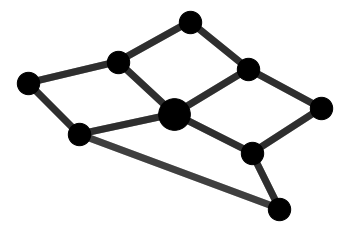

<Figure size 432x288 with 0 Axes>

In [11]:
explain_test(allnodes[40],needplot=True)